<a href="https://colab.research.google.com/github/Denismwangi01/Time-series-analysis/blob/main/Trendy_Tees'_Temporal_Troubles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#load the data

location_a = pd.read_csv("/content/Location_A.csv")
location_b = pd.read_csv("/content/Location_B.csv")

#covert month to datetime
location_a.set_index("Month", inplace=True)
location_b.set_index("Month", inplace= True)

location_a.head()

,Year 1,Year 2,Year 3,Year 4
Month,,,,
January,15153,17583,21235,22857
February,14800,19995,22903,25993
March,20190,20755,23455,26981
April,16648,16930,20115,22008
May,17018,19825,21945,25772


In [ ]:
location_b.head()

,Year 1,Year 2,Year 3,Year 4
Month,,,,
January,23345,26705,30187,33285
February,10267,27050,40377,22608
March,20509,18505,34693,28433
April,17089,26159,26958,35685
May,25145,24188,17926,31639


In [ ]:
location_a.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, January to December
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Year 1  12 non-null     int64
 1   Year 2  12 non-null     int64
 2   Year 3  12 non-null     int64
 3   Year 4  12 non-null     int64
dtypes: int64(4)
memory usage: 480.0+ bytes


In [ ]:
#function to clean the data
def clean_data(df):
  return df.replace('[\$,]', '', regex=True).astype(float)


location_a = clean_data(location_a)
location_b = clean_data(location_b)

In [ ]:
# Detect & Remove Outliers using IQR
for col in location_a.columns[1:]:
    Q1 = location_a[col].quantile(0.25)
    Q3 = location_a[col].quantile(0.75)
    IQR = Q3 - Q1
    location_a = location_a[(location_a[col] >= Q1 - 1.5 * IQR) & (location_a[col] <= Q3 + 1.5 * IQR)]

for col in location_b.columns[1:]:
    Q1 = location_b[col].quantile(0.25)
    Q3 = location_b[col].quantile(0.75)
    IQR = Q3 - Q1
    location_b = location_b[(location_b[col] >= Q1 - 1.5 * IQR) & (location_b[col] <= Q3 + 1.5 * IQR)]

# 1. Exploratory Data Analysis

In [ ]:
location_a.describe()

,Year 1,Year 2,Year 3,Year 4
count,12.000000,12.000000,12.000000,12.000000
mean,20417.750000,22388.750000,24961.083333,28688.416667
std,3836.931163,3979.043355,3348.812475,4488.802684
min,14800.000000,16930.000000,20115.000000,22008.000000
25%,16925.500000,19797.500000,22663.500000,25736.250000
50%,20556.500000,21559.000000,24339.000000,28026.000000
75%,23380.750000,24917.250000,27845.500000,32392.250000
max,26025.000000,29270.000000,30045.000000,35052.000000


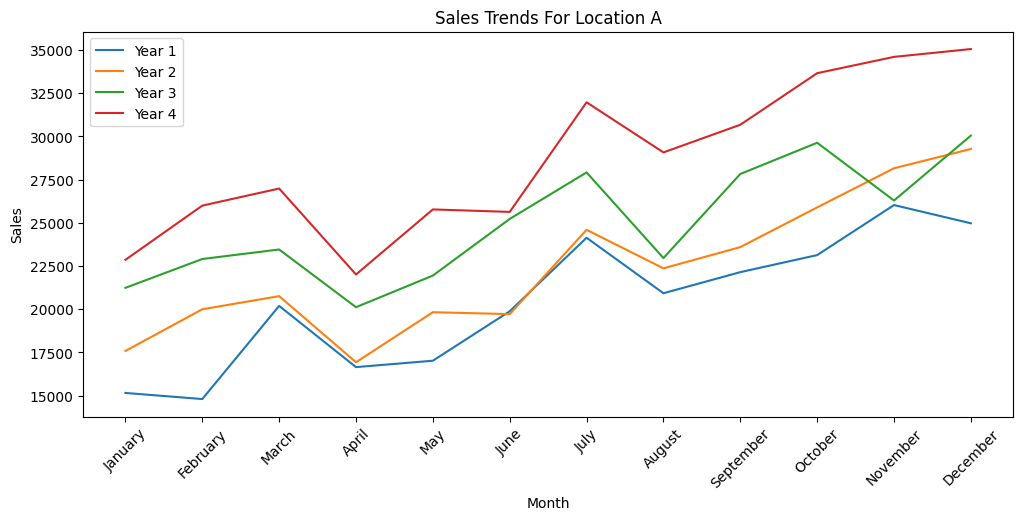

In [ ]:
# sales trends for Location A
plt.figure(figsize = (12,5))

for year in location_a.columns:
  plt.plot(location_a.index, location_a[year], label= year)

plt.title("Sales Trends For Location A")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.legend()
plt.show()

Year 4 has the highest sales throughout, reaching about $35,000 by December


Sales drop in April


The gap between Year 4 and other years is significant showing strong growth for this location over time.

#2. Time Series Decomposition

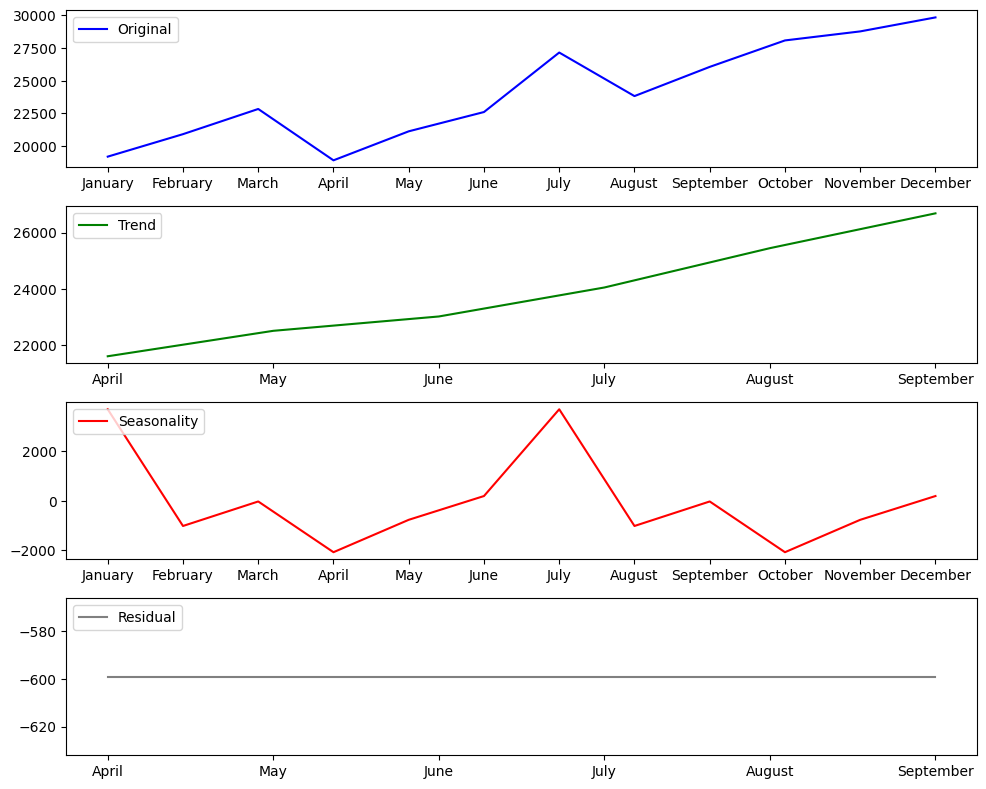

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition
decomposition = seasonal_decompose(location_a.mean(axis=1), model='additive', period=6)

# Plot decomposition results
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(location_a.mean(axis=1), label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='red')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='gray')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


clear upward trend in sales over time.

seasonal pattern fluctuates across months, meaning seasonality is present.


# 3. Forecasting Model Selection

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(location_a.mean(axis=1))
print(f"ADF Statistic: {result[0]:.4f}")
print(f"P-Value: {result[1]:.4f}")

ADF Statistic: 0.4312
P-Value: 0.9826


In [ ]:
# Normalize Data
def normalize(df):
    for col in df.columns[1:]:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
    return df

location_a = normalize(location_a)
location_b = normalize(location_b)

In [ ]:
# Prepare Data for Modeling
train_size = 9
y_train = location_a.iloc[:train_size, 1:].mean(axis=1)
y_test = location_a.iloc[train_size:, 1:].mean(axis=1)

# Reshape X_train and X_test
X_train = np.arange(len(y_train)).reshape(-1,)
X_test = np.arange(len(y_train), len(y_train) + len(y_test)).reshape(-1,)

# 4. Model Development & Evaluation

In [ ]:

# SARIMA Model
sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_sarima = sarima_model.fit()
y_pred_sarima = model_fit_sarima.forecast(steps=len(y_test))

# Prophet Model (Needs DataFrame with 'ds' and 'y' columns)
df_train = pd.DataFrame({'y': y_train})
df_train['ds'] = pd.to_datetime(location_a.index[:train_size] + " 2023")

df_test = pd.DataFrame({'y': y_test})
df_test['ds'] = pd.to_datetime(location_a.index[train_size:] + " 2023")
prophet = Prophet()
prophet.fit(df_train)
forecast = prophet.predict(df_test)
y_pred_prophet = forecast['yhat'].values

# Exponential Smoothing
ets = ExponentialSmoothing(y_train, trend='add', seasonal=None).fit()
y_pred_ets = ets.forecast(len(y_test))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnd9om0cn/brijtaiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnd9om0cn/9csiewoe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54216', 'data', 'file=/tmp/tmpnd9om0cn/brijtaiq.json', 'init=/tmp/tmpnd9om0cn/9csiewoe.json', 'output', 'file=/tmp/tmpnd9om0cn/prophet_modelmsvxvujf/prophet_model-20250313194042.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
19:40:42 - cmdstanpy - INFO - Chain [1] start processing
IN

In [ ]:
# Evaluation Function
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name}: MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}")

evaluate(y_test, y_pred_sarima, "SARIMA")
evaluate(y_test, y_pred_prophet, "Prophet")
evaluate(y_test, y_pred_ets, "Exponential Smoothing")

SARIMA: MAE=0.24, MSE=0.06, RMSE=0.25
Prophet: MAE=0.17, MSE=0.03, RMSE=0.17
Exponential Smoothing: MAE=0.17, MSE=0.03, RMSE=0.17


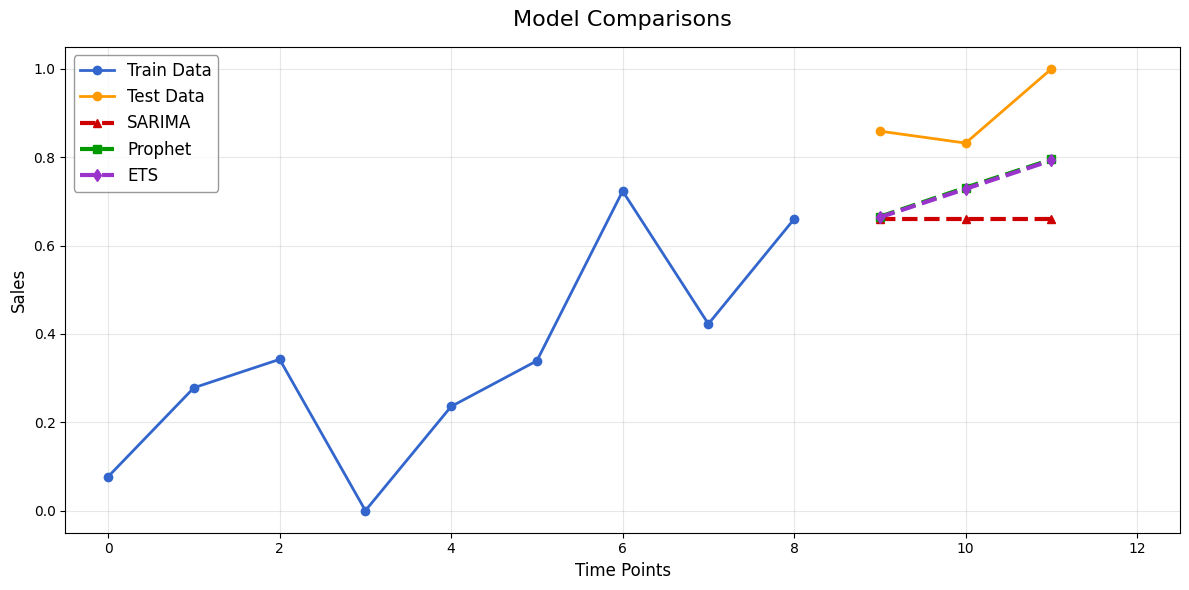

In [ ]:

# Visualizing Predictions
plt.figure(figsize=(12, 6))

# Plot training & test data
plt.plot(range(len(y_train)), y_train, label="Train Data", marker='o', color='#3366CC', linewidth=2)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label="Test Data", marker='o', color='#FF9900', linewidth=2)

# Plot predictions
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_sarima, label="SARIMA", linestyle="--", color='#CC0000', linewidth=3, marker='^')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_prophet, label="Prophet", linestyle="--", color='#009900', linewidth=3, marker='s')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_ets, label="ETS", linestyle="--", color='#9933CC', linewidth=3, marker='d')

plt.legend(loc='best', fontsize=12, frameon=True, facecolor='white', edgecolor='gray')
plt.title("Model Comparisons", fontsize=16, pad=15)
plt.grid(True, alpha=0.3)
plt.xlabel("Time Points", fontsize=12)
plt.ylabel("Sales", fontsize=12)

plt.xlim(-0.5, len(y_train) + len(y_test) + 0.5)
plt.tight_layout()
plt.show()

# 5.Scenario Planning

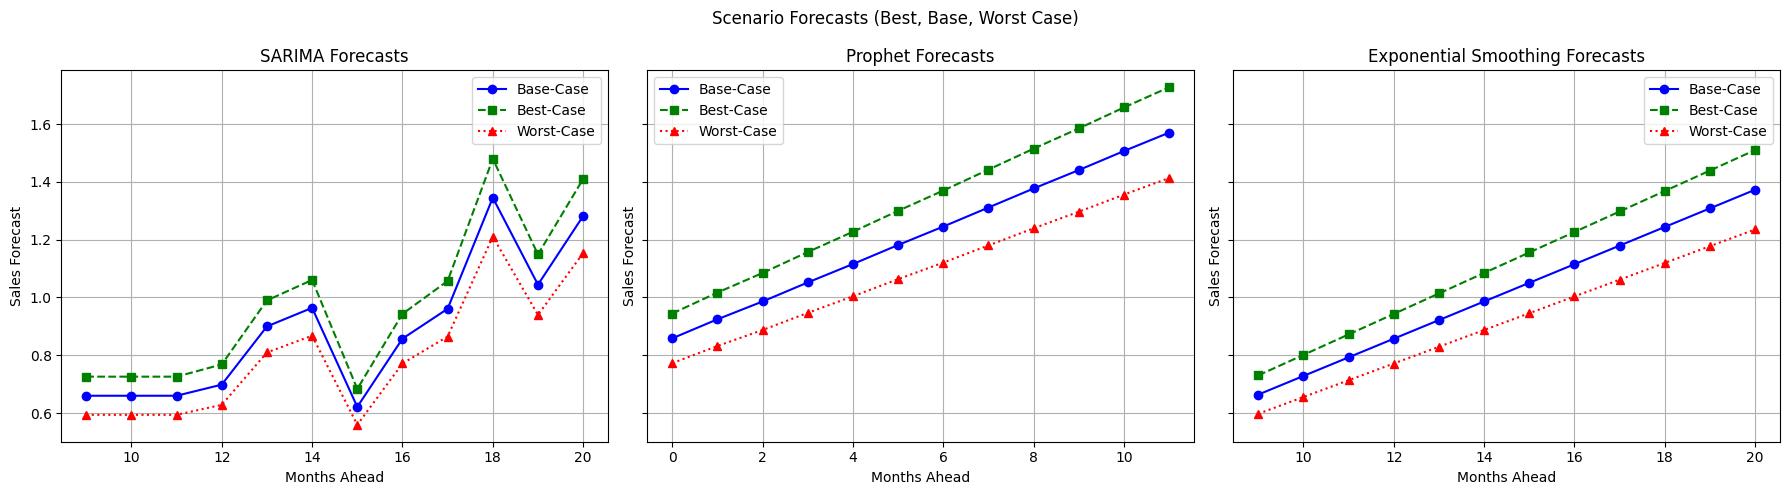

In [ ]:
import matplotlib.pyplot as plt

# Generate forecasts for the next 12 months
future_steps = 12

# SARIMA future predictions
y_pred_sarima_future = model_fit_sarima.forecast(steps=future_steps)

# Prophet future predictions
future_dates = pd.DataFrame({'ds': pd.date_range(start=df_test['ds'].max(), periods=future_steps, freq='M')})
forecast_future = prophet.predict(future_dates)
y_pred_prophet_future = forecast_future['yhat'].values

# Exponential Smoothing future predictions
y_pred_ets_future = ets.forecast(steps=future_steps)

# Apply scenario analysis
best_case_factor = 1.10
worst_case_factor = 0.90

scenarios = {
    "Base-Case": {
        "SARIMA": y_pred_sarima_future,
        "Prophet": y_pred_prophet_future,
        "Exponential Smoothing": y_pred_ets_future
    },
    "Best-Case": {
        "SARIMA": y_pred_sarima_future * best_case_factor,
        "Prophet": y_pred_prophet_future * best_case_factor,
        "Exponential Smoothing": y_pred_ets_future * best_case_factor
    },
    "Worst-Case": {
        "SARIMA": y_pred_sarima_future * worst_case_factor,
        "Prophet": y_pred_prophet_future * worst_case_factor,
        "Exponential Smoothing": y_pred_ets_future * worst_case_factor
    }
}

# Define colors, linestyles, and markers
colors = ["blue", "green", "red"]
linestyles = ["solid", "dashed", "dotted"]
markers = ["o", "s", "^"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

models = ["SARIMA", "Prophet", "Exponential Smoothing"]

for i, model in enumerate(models):
    ax = axes[i]

    # Plot scenarios separately for each model
    for j, (scenario, preds) in enumerate(scenarios.items()):
        ax.plot(preds[model], linestyle=linestyles[j], color=colors[j], marker=markers[j], label=scenario, markersize=6)

    ax.set_title(f"{model} Forecasts")
    ax.set_xlabel("Months Ahead")
    ax.set_ylabel("Sales Forecast")
    ax.grid(True)
    ax.legend()

plt.suptitle("Scenario Forecasts (Best, Base, Worst Case)")
plt.tight_layout()
plt.show()


# 7. Marketing Decisions

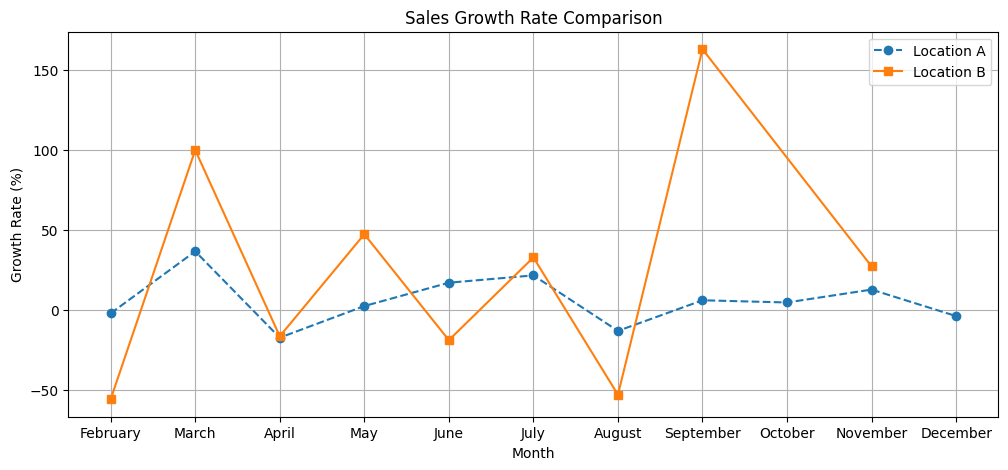

T-test Statistic: -0.79, P-value: 0.4523


In [ ]:
from scipy.stats import ttest_ind

# Compute percentage growth for each location
location_a["Growth"] = location_a.mean(axis=1).pct_change() * 100
location_b["Growth"] = location_b.mean(axis=1).pct_change() * 100
growth_a = location_a["Growth"].dropna()
growth_b = location_b["Growth"].dropna()

# Visualize Growth Rate Trends
plt.figure(figsize=(12, 5))
plt.plot(growth_a, label="Location A", marker="o", linestyle="dashed")
plt.plot(growth_b, label="Location B", marker="s", linestyle="solid")
plt.xlabel("Month")
plt.ylabel("Growth Rate (%)")
plt.title("Sales Growth Rate Comparison")
plt.legend()
plt.grid(True)
plt.show()

# Statistical Test
t_stat, p_value = ttest_ind(growth_a, growth_b, equal_var=False)
print(f"T-test Statistic: {t_stat:.2f}, P-value: {p_value:.4f}")
